## Трансформер, в котором энкодер заменен предобученным DistilBERT-ом 

Этот подход опирается на [базовый ноутбук](https://colab.research.google.com/github/girafe-ai/ml-mipt/blob/21f_advanced/homeworks_advanced/lab01_nlp/lab1_02_nlp_part2_nmt.ipynb) и 6-ой [туториал](https://colab.research.google.com/github/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb#scrollTo=P021gYDsU9kL) по seq2seq от bentrevett. Основные отличия от оригинала связаны с использованием [предобученного энкодера](https://huggingface.co/Geotrend/distilbert-base-ru-cased).

Работа состоит из следующих этапов:
1. С помощью библиотеки transformers загружается энкодер.
2. Данные подготавливаются к обучению. Так как предобученный BERT обучался со своим токенизатором, необходимо переделать процедуру токенизации предложений на русском, чтобы энкодер работал со знакомыми ему данными.
3. Описание класса декодера. Его обучение будет происходить с нуля.
4. Класс модели Seq2Seq целиком. Необходимо объединить предобученный энкодер с нашим декодером.
5. Обучение. Каждый этап сопровождается графиками лоссов на трейне и валидации, а также PPL и общим лоссом на тесте.
  - Сначала только декодер, потому что он пока ничего не знает о задаче и может испортить веса BERT-а, что-то знающего о языке.
    - Инициализация весов декодера с использованием torch.nn.init.xavier_uniform_.
    - Замораживание весов энкодера.
    - Обучение модели с learning rate decay при помощи torch.optim.lr_scheduler.ReduceLROnPlateau.
  - Теперь вся модель целиком.
    - Размораживание весов энкодера.
    - Обучение. Также применяется learning rate decay.
6. Результаты обучения.
  - Примеры работы модели и сравнение с входными данными и ground truth.
  - BLEU score


### Загрузка энкодера


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 56 kB 2.9 MB/s 
     |████████████████████████████████| 596 kB 37.9 MB/s 
     |████████████████████████████████| 895 kB 34.0 MB/s 
     |████████████████████████████████| 3.3 MB 35.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import transformers as ppb

encoder_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'Geotrend/distilbert-base-ru-cased')

tokenizer_ru = tokenizer_class.from_pretrained(pretrained_weights)
encoder_ru = encoder_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/130k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208M [00:00<?, ?B/s]

Some weights of the model checkpoint at Geotrend/distilbert-base-ru-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(encoder_ru)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(14283, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

### Подготовка данных к обучению

In [ ]:
import numpy as np

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy

import random
import time
import math

import os
import json

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!nvidia-smi

Sun Oct 24 21:09:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
--2021-10-24 21:09:48--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.1s    

2021-10-24 21:09:49 (105 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [ ]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


Предобученный BERT умеет работать только со знакомыми ему токенами, поэтому используем токенизатор, предоставляемый вместе с ним. Английский текст токенизируем с использованием spaCy.

In [ ]:
spacy_en = spacy.load('en_core_web_sm')
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_ru(text, tokenizer=tokenizer_ru):
    return tokenizer.encode(text, add_special_tokens=True)

Создаем датасет. Токенизатор BERT-а сам добавляет символы конца и начала.

In [ ]:
SRC = Field(tokenize=tokenize_ru,
            batch_first=True)

TRG = Field(tokenize=tokenize_en,
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True,
            batch_first=True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

SRC.build_vocab(train_data, min_freq = 1)
TRG.build_vocab(train_data, min_freq = 2)

print()
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500

Unique tokens in source (ru) vocabulary: 8944
Unique tokens in target (en) vocabulary: 10297


Русский текст сразу переводится в числовые значения. Английский — нет.

In [ ]:
print("Part of russian vocab:", SRC.vocab.itos[::1000])
print("Part of english vocab:", TRG.vocab.itos[::1000])

Part of russian vocab: ['<unk>', 2910, 2630, 6375, 2893, 1876, 5509, 4858, 5297]
Part of english vocab: ['<unk>', '38', 'tracks', 'wishing', 'kalamies', 'safed', 'kiwi', 'agriculture', 'finsbury', 'nicklaus', 'tussauds']


In [ ]:
print("Example of data:")
print("English (target):", vars(train_data.examples[9])["trg"])
print("Russian (source):", vars(train_data.examples[9])["src"])

Example of data:
English (target): ['other', 'facilities', 'offered', 'at', 'the', 'property', 'include', 'grocery', 'deliveries', ',', 'laundry', 'and', 'ironing', 'services', '.']
Russian (source): [11, 3005, 3686, 5063, 1893, 9257, 4040, 9352, 457, 25, 11423, 5646, 1782, 4324, 173, 8119, 10460, 3549, 11423, 27, 12]


Посчитаем максимальные длины последовательностей для каждого из языков. Это понадобится в дальнейшем для создания позиционных эмбеддингов, инференса и создания масок.

In [ ]:
max_ru_len = 0
max_en_len = 0
for curr_data in (train_data, valid_data, test_data):
    for example in curr_data.examples:
        curr_ru_len = len(vars(example)["src"])
        if curr_ru_len > max_ru_len:
            max_ru_len = curr_ru_len

        curr_en_len = len(vars(example)["trg"])
        if curr_en_len > max_en_len:
            max_en_len = curr_en_len


print("Max RU sentence length:", max_ru_len)
print("Max EN sentence length:", max_en_len)

Max RU sentence length: 152
Max EN sentence length: 90


Добавим вручную паддинги к русскому тексту (индекс паддинга — 0).

In [ ]:
for curr_data in (train_data, valid_data, test_data):
    for example in curr_data.examples:
        curr_data = vars(example)
        curr_data["src"] += [0]*(max_ru_len - len(curr_data["src"]))

In [ ]:
print("Example of data:")
print("English (target):", vars(train_data.examples[9])["trg"])
print("Russian (source):", vars(train_data.examples[9])["src"])

Example of data:
English (target): ['other', 'facilities', 'offered', 'at', 'the', 'property', 'include', 'grocery', 'deliveries', ',', 'laundry', 'and', 'ironing', 'services', '.']
Russian (source): [11, 3005, 3686, 5063, 1893, 9257, 4040, 9352, 457, 25, 11423, 5646, 1782, 4324, 173, 8119, 10460, 3549, 11423, 27, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# рабочий девайс
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

def _len_sort_key(x):
    return len(x.src)

# такой размер батча подходит для обучения половины модели
# для обучения полной модели его нужно будет уменьшить вдвое,
# пересоздав итераторы
BATCH_SIZE = 128

# итераторы, группирующие предложения с примерно одинаковой длиной в батчи
# и автоматически добавляющие паддинги (только для английского, так как
# в русском все уже добавлено вручную)
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE, 
    device=device,
    sort_key=_len_sort_key
)

Device: cuda


Пример батча.

In [ ]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 128x58 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 128x152 (GPU 0)]
torch.Size([128, 152]) torch.Size([128, 58])


Так как итераторы изменили индексы токенайзера на свои, требуется поменять их обратно, чтобы BERT их понимал. Также нужно добавить маску, потому что в наших предложениях есть паддинги и мы не хотим, чтобы self-attention в модели обуславливался на них.

In [ ]:
def prepare_encoder_batch(source, SRC_vocab):
    n_rows = source.shape[0]
    n_cols = source.shape[1]
    res = torch.zeros((n_rows, n_cols)).type(torch.LongTensor)
    res_mask = torch.zeros((n_rows, n_cols)).type(torch.LongTensor)
    for i, row in enumerate(source):
        for j, item in enumerate(row):
            if item == 0:
                res[i, j] = item
                res_mask[i, j] = 0
            else:
                res[i, j] = SRC_vocab.itos[item]
                res_mask[i, j] = 1

    # res = [batch size, src len]
    # res_mask = [batch size, 1, 1, src len]

    return res, res_mask.unsqueeze(1).unsqueeze(2)

Пример работы энкодера. Его выход можно получить по ключу *'last_hidden_state'*.

In [ ]:
example_batch, example_batch_mask = prepare_encoder_batch(x.src, SRC.vocab)

outputs = encoder_ru(example_batch, attention_mask=example_batch_mask)

outputs['last_hidden_state'].shape

torch.Size([128, 152, 768])

### Классы декодера и его составных элементов

Во многом повторяются идеи [туториала](https://colab.research.google.com/github/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb#scrollTo=P021gYDsU9kL) от bentrevett.

In [ ]:
# основной класс, в котором применяются эмбеддинги токенов и их позиций в
# предложении, слои декодера, каждый из которых содержит по 2 self-attention'а
# и финальный полносвязный слой, а также dropout
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length=100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        

    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        # trg = [batch size, trg len]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        # pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        # trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            # trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            trg = layer(trg, enc_src, trg_mask, src_mask)
        
        # trg = [batch size, trg len, hid dim]
        # attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        # output = [batch size, trg len, output dim]
            
        # return output, attention
        return output



# класс слоя декодера, внутри которого применяются LayerNorm, self-attention над
# входом декодера и еще один self-attention над выходом энкодера, затем
# FeedForward слой и dropout
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        # trg = [batch size, trg len, hid dim]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]
        
        # self attention
        # _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        _trg = self.self_attention(trg, trg, trg, trg_mask)
        
        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        # trg = [batch size, trg len, hid dim]
            
        # encoder attention
        # _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        _trg = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        # trg = [batch size, trg len, hid dim]
        
        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        # trg = [batch size, trg len, hid dim]
        # attention = [batch size, n heads, trg len, src len]
        
        # return trg, attention
        return trg



# MultiHead self-attention слой
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        

    def forward(self, query, key, value, mask=None):
        
        batch_size = query.shape[0]
        
        # query = [batch size, query len, hid dim]
        # key = [batch size, key len, hid dim]
        # value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        # Q = [batch size, query len, hid dim]
        # K = [batch size, key len, hid dim]
        # V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # Q = [batch size, n heads, query len, head dim]
        # K = [batch size, n heads, key len, head dim]
        # V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        # energy = [batch size, n heads, query len, key len]
        
        # where mask value is 0 put -1e10
        if mask is not None:
            energy = energy.masked_fill(mask==0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        # attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        # x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        # x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        # x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        # x = [batch size, query len, hid dim]
        
        # return x, attention
        return x



# полносвязный слой, применяющийся к выходам self-attention слоев
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, x):
        
        # x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        # x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        # x = [batch size, seq len, hid dim]
        
        return x

### Класс Seq2Seq модели

Нужно объединить предобученный энкодер и наш декодер в одну корректно работающую модель.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.trg_pad_idx = trg_pad_idx
        self.device = device
    

    def make_trg_mask(self, trg):
        
        # trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        # trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        # trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        # trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask


    def forward(self, src, src_mask, trg):
        
        # src = [batch size, src len]
        # trg = [batch size, trg len]
                
        # src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        # src_mask = [batch size, 1, 1, src len]
        # trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)['last_hidden_state']
        
        # enc_src = [batch size, src len, hid dim]
                
        # output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        output = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        # output = [batch size, trg len, output dim]
        # attention = [batch size, n heads, trg len, src len]
        
        # return output, attention
        return output

### Обучение

#### Объявляение модели и функций, используемых при обучении

In [ ]:
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 768
DEC_LAYERS = 4
DEC_HEADS = 8
DEC_PF_DIM = 1536
DEC_DROPOUT = 0.1
MAX_EN_LEN = max_en_len

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(encoder_ru, dec, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 98,158,393 trainable parameters


In [ ]:
print(model)

Seq2Seq(
  (encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(14283, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_features

Стандартный цикл обучения, адаптированный под нашу модель. Дополнительно выходит графики лосса на трейне и валидации, причем в нескольких вариантах, чтобы была ясна как локальная, так и глобальная картина сходимости.

In [ ]:
def train(model, iterator, optimizer, criterion, clip, SRC_vocab, device,
          train_history=None, valid_history=None, verbose_train_history=None):
    
    model.train()
    
    epoch_loss = 0
    history = list()
    for i, batch in enumerate(iterator):
        
        src = batch.src
        src, src_mask = prepare_encoder_batch(src, SRC_vocab)
        src = src.to(device)
        src_mask = src_mask.to(device)
        trg = batch.trg

        # src = [batch size, src len]
        # src_mask = [batch size, 1, 1, src len] 
        
        optimizer.zero_grad()
        
        output = model(src, src_mask, trg[:,:-1])
       
        # output = [batch size, trg len - 1, output dim]
        # trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        # output = [batch size * trg len - 1, output dim]
        # trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

            clear_output(True)
            ax[0].plot(history, label="train")
            ax[0].set_xlabel('Batch')
            ax[0].set_ylabel('Loss')
            ax[0].set_title('Train loss on current epoch')
            ax[0].grid(which='major', color='#DDDDDD', linewidth=0.8)
            ax[0].legend()
            if train_history is not None:
                ax[1].plot(train_history, label='train')
                ax[1].set_xlabel('Epoch')
                ax[1].set_ylabel('Loss')
                ax[1].set_title('General loss history')
                ax[1].grid(which='major', color='#DDDDDD', linewidth=0.8)
            if valid_history is not None:
                ax[1].plot(valid_history, label='validation')
                ax[1].legend()
            if verbose_train_history is not None:
                ax[2].plot(verbose_train_history, label="train")
                ax[2].set_xlabel('Batch iteration')
                ax[2].set_ylabel('Loss')
                ax[2].set_title('Verbose train history')
                ax[2].grid(which='major', color='#DDDDDD', linewidth=0.8)
                ax[2].legend()
            # plt.legend()
            
            plt.show()
        
    return epoch_loss / len(iterator), history

Функция для validation и test стадий. Повторяет train, но без вычисления градиентов и шага оптимизатора.

In [ ]:
def evaluate(model, iterator, criterion, SRC_vocab, device):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            src, src_mask = prepare_encoder_batch(src, SRC_vocab)
            src = src.to(device)
            src_mask = src_mask.to(device)
            trg = batch.trg

            # src = [batch size, src len]
            # src_mask = [batch size, 1, 1, src len] 

            output = model(src, src_mask, trg[:,:-1])
            
            # output = [batch size, trg len - 1, output dim]
            # trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            # output = [batch size * trg len - 1, output dim]
            # trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Для вычисления времени на эпоху.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Веса модели и историю обучения сохраняем на гугл диск, так как колаб всегда может отключиться в самый неподходящий момент.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Обучение декодера

Инициализируем веса декодера с помощью nn.init.xavier_uniform_.

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.decoder.apply(initialize_weights)

Decoder(
  (tok_embedding): Embedding(10297, 768)
  (pos_embedding): Embedding(100, 768)
  (layers): ModuleList(
    (0): DecoderLayer(
      (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (enc_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ff_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (self_attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=768, out_features=768, bias=True)
        (fc_k): Linear(in_features=768, out_features=768, bias=True)
        (fc_v): Linear(in_features=768, out_features=768, bias=True)
        (fc_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder_attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=768, out_features=768, bias=True)
        (fc_k): Linear(in_features=768, out_features=768, bias=True)
        (fc_v): Linear(in_features=768, out_feat

Замораживаем веса энкодера, чтобы ничего не поломать на старте.

In [ ]:
def set_requires_grad(model_part, set_to=True):
    for param in model_part.parameters():
        param.requires_grad = set_to

set_requires_grad(model.encoder, set_to=False)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 44,267,065 trainable parameters


Обучать будем при помощи Adam с learning rate decay при выходе на плато, осуществляемого scheduler.

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.3, patience=1, threshold=0.1, verbose=True
)

Обучение. Выводятся графики лоссов и записывается история обучения.

P.S. На центральном графике должна быть легенда (см. train()), но ее там почему-то не оказалось. Оранжевый график для валидации, синий — для трейна. После обучения декодера train() был немного переписан, чтобы отображалась легенда, на графике для обучения всей модели уже указано, что есть что.

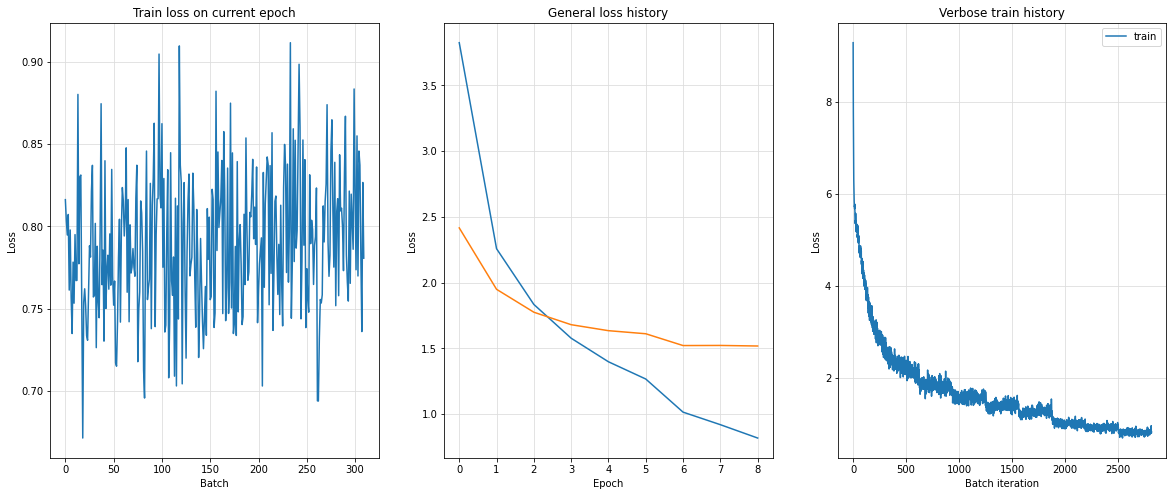

Epoch    10: reducing learning rate of group 0 to 1.3500e-05.
Epoch: 10 | Time: 20m 21s
	Train Loss: 0.789 | Train PPL:   2.201
	 Val. Loss: 1.525 |  Val. PPL:   4.594


In [ ]:
train_history = []
valid_history = []
verbose_train_history = []

N_EPOCHS = 10
CLIP = 1
model_save_path = '/content/drive/MyDrive/Colab Notebooks/girafe-ai assignments/EN-RU models/Pretrained-BERT-enc-1.pt'
history_save_path = '/content/drive/MyDrive/Colab Notebooks/girafe-ai assignments/EN-RU models/Pretrained-BERT-enc_history-1.json'

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, history = train(model, train_iterator, optimizer,
                                criterion, CLIP, SRC.vocab, device,
                                train_history=train_history,
                                valid_history=valid_history,
                                verbose_train_history=verbose_train_history)
    
    valid_loss = evaluate(model, valid_iterator,
                          criterion, SRC.vocab, device)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_save_path)
    
    scheduler.step(valid_loss)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    verbose_train_history.extend(history)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


verbose_train_history = [x.item() for x in verbose_train_history]
whole_history = {
    "train_history": train_history,
    "valid_history": valid_history,
    "verbose_train_history": verbose_train_history
}

with open(history_save_path, "w") as history_file:
    json.dump(whole_history, history_file)

Лосс на тесте.

In [ ]:
model_save_path = '/content/drive/MyDrive/Colab Notebooks/girafe-ai assignments/EN-RU models/Pretrained-BERT-enc-1.pt'
model.load_state_dict(torch.load(model_save_path))

test_loss = evaluate(model, test_iterator, criterion, SRC.vocab, device)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.527 | Test PPL:   4.603 |


#### Обучение модели целиком

Размораживаем веса энкодера

In [ ]:
set_requires_grad(model.encoder, set_to=True)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 98,158,393 trainable parameters


Модель стала в два раза больше, поэтому на коллабовский GPU с BATCH_SIZE=128 уже не влезает. Переопределяем итераторы с меньшим размером батча.

In [ ]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE, 
    device=device,
    sort_key=_len_sort_key
)

Обучение всей модели.

##### Warmup обучение одну эпоху

Чтобы посмотреть, как модель реагирует на выбранный *LEARNING_RATE*. При обучении декодера этот параметр изначально был равен 5e-4. Затем он упал до 1.35e-5. Тут был выбрал 5e-6.

In [ ]:
LEARNING_RATE = 0.000005

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.3, patience=1, threshold=0.1, verbose=True
)

No handles with labels found to put in legend.


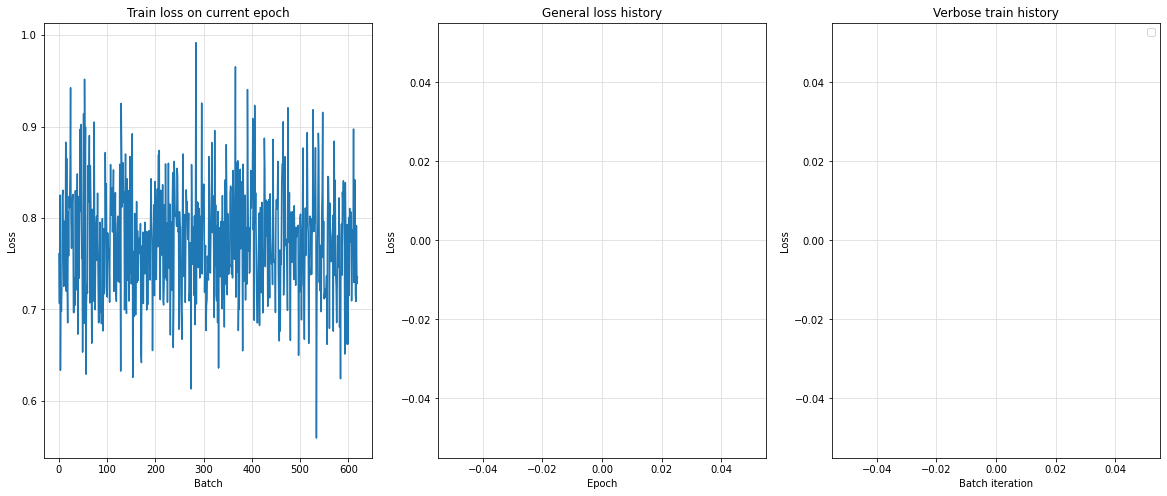

Epoch: 01 | Time: 30m 31s
	Train Loss: 0.774 | Train PPL:   2.169
	 Val. Loss: 1.496 |  Val. PPL:   4.463


In [ ]:
train_history = []
valid_history = []
verbose_train_history = []

N_EPOCHS = 1
CLIP = 1
model_save_path = '/content/drive/MyDrive/Colab Notebooks/girafe-ai assignments/EN-RU models/Pretrained-BERT-enc-2.pt'
history_save_path = '/content/drive/MyDrive/Colab Notebooks/girafe-ai assignments/EN-RU models/Pretrained-BERT-enc_history-2.json'

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, history = train(model, train_iterator, optimizer,
                                criterion, CLIP, SRC.vocab, device,
                                train_history=train_history,
                                valid_history=valid_history,
                                verbose_train_history=verbose_train_history)
    
    valid_loss = evaluate(model, valid_iterator,
                          criterion, SRC.vocab, device)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_save_path)
    
    scheduler.step(valid_loss)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    verbose_train_history.extend(history)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


verbose_train_history = [x.item() for x in verbose_train_history]
whole_history = {
    "train_history": train_history,
    "valid_history": valid_history,
    "verbose_train_history": verbose_train_history
}

with open(history_save_path, "w") as history_file:
    json.dump(whole_history, history_file)

##### Полноценное обучение модели целиком

Начальный *LEARNING_RATE* равен 2.5e-6.

In [ ]:
LEARNING_RATE = 0.0000025

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.3, patience=1, threshold=0.1, verbose=True
)

Во время этой стадии обучения коллаб отключился, отработав первые 2 эпохи. Возобновление обучения осуществляется при помощи кода ниже.

In [ ]:
# use to reload model
model_save_path = '/content/drive/MyDrive/Colab Notebooks/girafe-ai assignments/EN-RU models/Pretrained-BERT-enc-2-2.pt'
model.load_state_dict(torch.load(model_save_path))

# Load histories
history_save_path_1 = '/content/drive/MyDrive/Colab Notebooks/girafe-ai assignments/EN-RU models/Pretrained-BERT-enc_history-1.json'
with open(history_save_path_1, 'r') as hsp1:
    whole_history_1 = json.load(hsp1)

history_save_path_2 = '/content/drive/MyDrive/Colab Notebooks/girafe-ai assignments/EN-RU models/Pretrained-BERT-enc_history-2.json'
with open(history_save_path_2, 'r') as hsp2:
    whole_history_2 = json.load(hsp2)

train_history = []
valid_history = []
verbose_train_history = []

train_history.extend(whole_history_1['train_history'])
train_history.extend(whole_history_2['train_history'])

valid_history.extend(whole_history_1['valid_history'])
valid_history.extend(whole_history_2['valid_history'])

verbose_train_history.extend(whole_history_1['verbose_train_history'])
verbose_train_history.extend(whole_history_2['verbose_train_history'])

Лосс с этих двух эпох сохранился только в виде графиков.

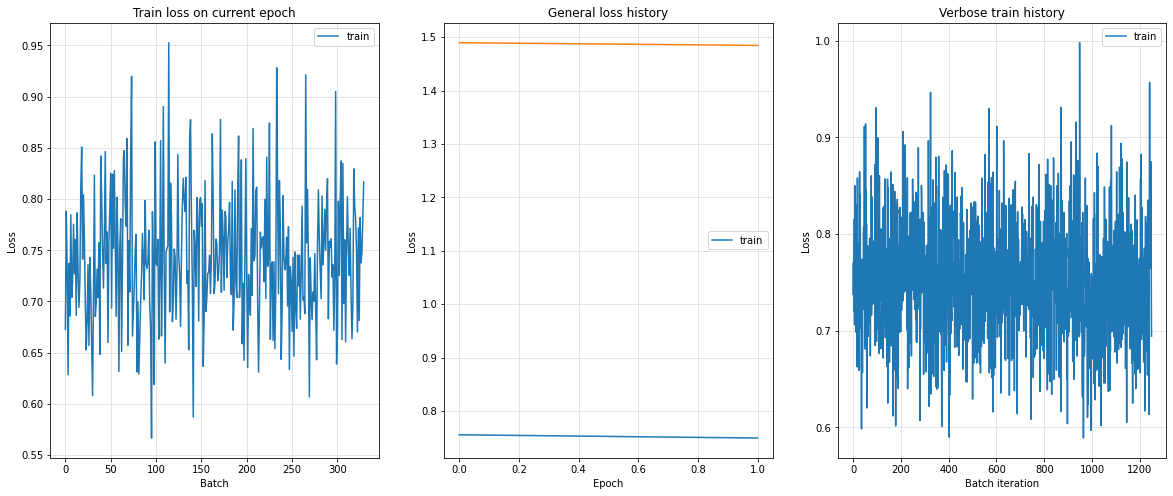

In [ ]:
train_history = []
valid_history = []
verbose_train_history = []

N_EPOCHS = 10
CLIP = 1
model_save_path = '/content/drive/MyDrive/Colab Notebooks/girafe-ai assignments/EN-RU models/Pretrained-BERT-enc-2-2.pt'
history_save_path = '/content/drive/MyDrive/Colab Notebooks/girafe-ai assignments/EN-RU models/Pretrained-BERT-enc_history-2-2.json'

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, history = train(model, train_iterator, optimizer,
                                criterion, CLIP, SRC.vocab, device,
                                train_history=train_history,
                                valid_history=valid_history,
                                verbose_train_history=verbose_train_history)
    
    valid_loss = evaluate(model, valid_iterator,
                          criterion, SRC.vocab, device)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_save_path)
    
    scheduler.step(valid_loss)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    verbose_train_history.extend(history)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


verbose_train_history = [x.item() for x in verbose_train_history]
whole_history = {
    "train_history": train_history,
    "valid_history": valid_history,
    "verbose_train_history": verbose_train_history
}

with open(history_save_path, "w") as history_file:
    json.dump(whole_history, history_file)

Продолжаем обучение.

In [ ]:
LEARNING_RATE = 0.0000025 * 0.8

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=1, threshold=0.1, verbose=True
)

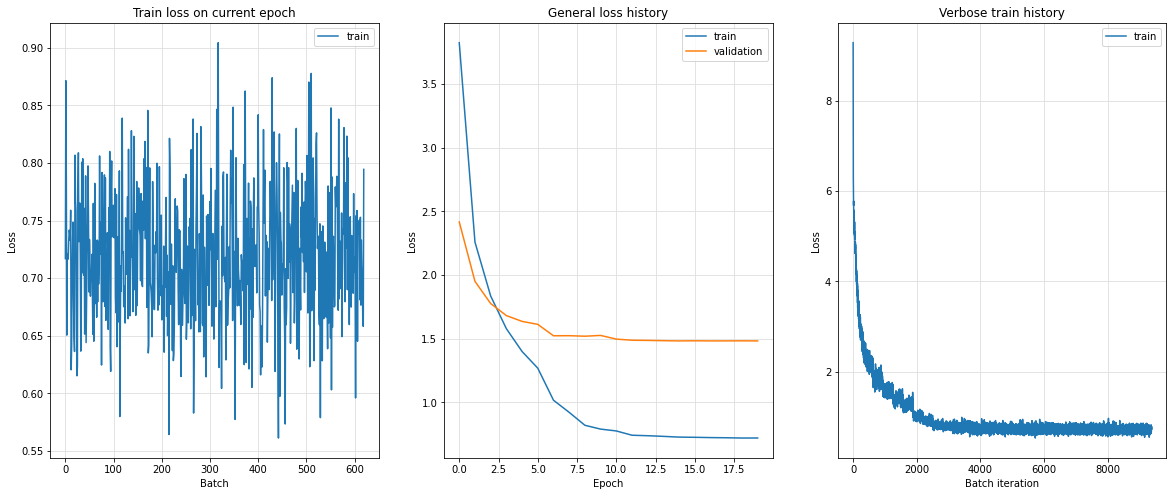

Epoch: 10 | Time: 29m 19s
	Train Loss: 0.719 | Train PPL:   2.051
	 Val. Loss: 1.481 |  Val. PPL:   4.399


AttributeError: ignored

In [ ]:
N_EPOCHS = 10
CLIP = 1
model_save_path = '/content/drive/MyDrive/Colab Notebooks/girafe-ai assignments/EN-RU models/Pretrained-BERT-enc-2-3.pt'
history_save_path = '/content/drive/MyDrive/Colab Notebooks/girafe-ai assignments/EN-RU models/Pretrained-BERT-enc_history-2-3.json'

best_valid_loss = 1.499

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, history = train(model, train_iterator, optimizer,
                                criterion, CLIP, SRC.vocab, device,
                                train_history=train_history,
                                valid_history=valid_history,
                                verbose_train_history=verbose_train_history)
    
    valid_loss = evaluate(model, valid_iterator,
                          criterion, SRC.vocab, device)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_save_path)
    
    scheduler.step(valid_loss)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    verbose_train_history.extend(history)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Похоже, что дальше обучать не имеет смысла.

На этапе сохранения истории появилась ошибка, так как verbose_train_history состоял из float'ов и numpy массивов из одного элемента. Ниже сохранение отработало корректно. Само обучение завершилось полностью.

In [ ]:
verbose_train_history = [x if isinstance(x, float) else x.item() for x in verbose_train_history]
whole_history = {
    "train_history": train_history,
    "valid_history": valid_history,
    "verbose_train_history": verbose_train_history
}

with open(history_save_path, "w") as history_file:
    json.dump(whole_history, history_file)

Проверка лосса на тесте.

In [ ]:
model_save_path = '/content/drive/MyDrive/Colab Notebooks/girafe-ai assignments/EN-RU models/Pretrained-BERT-enc-2-3.pt'
model.load_state_dict(torch.load(model_save_path))

start_time = time.time()
test_loss = evaluate(model, test_iterator, criterion, SRC.vocab, device)
end_time = time.time()

eval_mins, eval_secs = epoch_time(start_time, end_time)
print(f'Test evaluation time: {eval_mins}m {eval_secs}s')

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

Test evaluation time: 3m 8s
| Test Loss: 1.495 | Test PPL:   4.460 |


### Результаты обучения

#### Примеры работы модели и сравнение с входными данными и ground truth


Функция для инференса модели. Работает как на данных из итераторов, так и на пользовательских предложениях, подаваемых в виде обычной строки.

In [ ]:
def translate_sentence(sentence, tokenizer_ru, trg_field, model, device, max_len=100):
    
    model.eval()
        
    if isinstance(sentence, str):
        tokens = tokenizer_ru.encode(sentence, add_special_tokens=True)
    else:
        # if sentence is from iterator it's already tokenized
        # 0 is pad token, we don't need it
        tokens = [token for token in sentence if token != 0]
        
    # tokens are already numericalized
    src_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)
    
    src_mask = (src_tensor != 0).unsqueeze(1).unsqueeze(2).type(torch.LongTensor).to(device)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)['last_hidden_state']

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:]

In [ ]:
print("Custom sentence example:")
sentence = "Сегодня я живу в отеле"
print(translate_sentence(sentence, tokenizer_ru, TRG, model, device, max_len=100))
print()


print("Example from iterators:")
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']
print(f'src = {src}')
print(f'trg = {trg}')

translation = translate_sentence(src, tokenizer_ru, TRG, model, device)

print(f'predicted trg = {translation}')

Custom sentence example:
['the', 'hotel', 'is', 'open', 'every', 'day', '.', '<eos>']

Example from iterators:
src = [11, 137, 2656, 184, 2680, 1375, 2894, 6693, 457, 26, 2266, 13807, 173, 165, 13812, 7377, 10778, 9056, 63, 393, 2713, 1251, 10, 972, 1267, 779, 184, 11683, 1146, 173, 175, 9340, 1451, 674, 10524, 26, 175, 9340, 1451, 182, 186, 9835, 10185, 657, 3119, 173, 180, 10125, 877, 182, 10486, 8409, 288, 5040, 9960, 2831, 27, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
trg = ['each', 'of', 'the', 'résidence', '’s', 'apartments', 'and', 'studios', 'has', 'a', 'kitchen', 'or', 'kitchenette', 'equipped', 'with', 'a', 'fridge', ',', 'cooker', 'and', 'electric', 'hobs', '.', 'there', 'is', 'also', 'a', 'seating', 'area', 'in', 'each', '.']
predicte

Читать листы из сток можно, но гораздо лучше читать что-то более приближенное к обычным предложениям. Функции ниже частично решают эту задачу, хотя предложения на русском языке декодировать обратно оказалось не самой тривиальной задачей.

In [ ]:
def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>',
                                                '<unk>', '<pad>',
                                                '[CLS]', '[UNK]',
                                                '[SEP]', '[PAD]']):
    return [x for x in mystr if x not in tokens_to_remove]


# знаки пунктуации, пищущиеся со словами слитно
punct_signs = ['.', '.\n', ',', ',\n', '?', '?\n', '!', '!\n', '»', '»\n',
               ';', ';\n', '«']

def unsplit_punct(sentence):
    changed_sent = list()
    for word in sentence.split(" "):
        if word in punct_signs[:-1] and len(changed_sent) > 0:
            changed_sent[-1] += word
        elif len(changed_sent) > 0 and changed_sent[-1] == punct_signs[-1]:
            changed_sent[-1] += word
        else:
            changed_sent.append(word)
        
    return " ".join(changed_sent)


def print_human_readable_translations(sentence, tokenizer_ru, trg_field, model,
                                      device, max_len=100, real_translation=None):

    translation = translate_sentence(sentence, tokenizer_ru, trg_field, model, device, max_len=100)
    translation = remove_tech_tokens(translation)
    translation = " ".join(translation)
    translation = unsplit_punct(translation)

    # Sentence not from dataset
    if isinstance(sentence, str):
        print("Given sentence:", sentence)
        print("Model translation:", translation)
    else:
        # Sentence from dataset
        sentence = [tokenizer_ru.convert_ids_to_tokens(token) for token in sentence]
        sentence = remove_tech_tokens(sentence)
        sentence = unsplit_punct(" ".join(sentence))
        print("Given sentence:", sentence)

        if real_translation is not None:
            real_translation = remove_tech_tokens(real_translation)
            real_translation = unsplit_punct(" ".join(real_translation))
            print("Real translation:", real_translation)

        print("Model translation:", translation)

In [ ]:
print_human_readable_translations(sentence, tokenizer_ru, TRG, model,
                                  device, max_len=100, real_translation=None)

Given sentence: Сегодня я живу в отеле
Model translation: the hotel is open every day.


In [ ]:
print_human_readable_translations(src, tokenizer_ru, TRG, model,
                                  device, max_len=100, real_translation=trg)

Given sentence: В числе у ##до ##б ##ств номер ##ов - ст ##удио и а ##пар ##там ##ентов комплекса R ##é ##side ##nce го ##сти ##ный у ##гол ##ок и к ##ух ##ня или мини - к ##ух ##ня с х ##оло ##дил ##ь ##ником и п ##лит ##ой с электр ##ическим ##и кон ##фор ##ками.
Real translation: each of the résidence ’s apartments and studios has a kitchen or kitchenette equipped with a fridge, cooker and electric hobs. there is also a seating area in each.
Model translation: each studio at résidence comes with a seating area and a kitchen equipped with a fridge and a stovetop. there is also a kitchenette with electric hobs.


#### BLEU score

Посчитаем финальное качество нашей модели.

In [ ]:
import tqdm
from torchtext.data.metrics import bleu_score
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu(data, tokenizer_ru, trg_field, model, device, max_len=100):
    
    trgs = []
    pred_trgs = []
    
    for datum in tqdm.tqdm(data):
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg = translate_sentence(src, tokenizer_ru, trg_field, model, device, max_len=100)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs), corpus_bleu(trgs, pred_trgs)

In [ ]:
# Note: this takes around 10-20 minutes

bleu_score, corpus_bleu_score = calculate_bleu(test_data, tokenizer_ru, TRG, model, device, max_len=100)
print(f'BLEU score torchtext = {bleu_score*100:.2f}')
print(f'BLEU score nltk = {corpus_bleu_score*100:.2f}')

100%|██████████| 7500/7500 [16:50<00:00,  7.42it/s]


BLEU score torchtext = 32.12
BLEU score nltk = 32.12
